In [1]:
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score
from sklearn.linear_model import LinearRegression
from numpy import mean
from numpy import absolute
from numpy import sqrt
import numpy as np 
import pandas as pd
import seaborn as sns; sns.set()
%matplotlib inline 
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score, auc

In [2]:
testfile = 'Bladder Project pCR Prediction Data Updated 32422.txt'
df=pd.read_csv(testfile,sep='\t',index_col=0)
display(df)

,pCR,Age,Sex,Race,Urothelial,Smoking,NAC,MIBC,Incidental PC,utDNA,TF99,TMBc,TMB
ID,,,,,,,,,,,,,
WBC1045,0,63,1,1,1,1,1,1,1,2.4,2.400,340,1
WBC1050,1,63,2,1,1,1,1,1,0,0.0,2.500,74,0
WBC1058,0,78,1,1,1,0,0,1,0,5.9,2.400,136,0
WBC1062,0,77,1,1,0,1,1,1,0,2.4,1.600,170,0
WBC1063,1,67,1,1,1,0,1,1,0,0.0,1.700,40,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
WBC1312,1,61,1,1,1,0,1,0,0,0.0,0.000,60,0
WBC1313,0,48,1,1,0,0,1,1,0,1.9,18.300,272,1
WBC1314,1,73,2,1,1,1,1,1,0,0.3,0.000,272,1


In [3]:
def perform_cv(operation, cols):
    df_test = df.copy()
    df_test['Operation'] = operation
    df_test = df_test[cols]

    # create loocv procedure
    cv = LeaveOneOut()
    X=df_test.drop(['pCR'],axis=1).to_numpy()
    y=df_test["pCR"].copy().to_numpy()

    # enumerate splits
    y_true, y_pred, y_proba = list(), list(), list()
    X_df = df_test.drop(['pCR'],axis=1)
    df_features = pd.DataFrame(index=X_df.columns)
    df_std = pd.DataFrame(index=X_df.columns)
    i = 0
    for train_ix, test_ix in cv.split(X):
        # split data
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y[train_ix], y[test_ix]

        # fit model
        model = RandomForestClassifier(n_estimators=2000, random_state=42)
        model.fit(X_train, y_train)
        
        # find the best threshold
        pred_train = model.predict_proba(X_train)[:,1]
        
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, pred_train)
        sens_train_arr = tpr_train
        spec_train_arr = 1 - fpr_train
        gmeans_train = np.sqrt(sens_train_arr * spec_train_arr)
        ix_train = np.argmax(gmeans_train)
        thresh = thresholds_train[ix_train]

        # evaluate model
        yprob = model.predict_proba(X_test)[:,1]
        yhat = list((yprob >= thresh).astype(int))

        y_proba.append(yprob[0])
        y_true.append(y_test[0])
        y_pred.append(yhat[0])
        std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
        importances = model.feature_importances_
        df_features['Trial ' + str(i)] = importances
        df_std['Trial ' + str(i)] = std
        i += 1

    return y_proba, y_true, y_pred, df_features, df_std

In [4]:
cols = ['pCR', 'Age', 'Race', 'NAC', 'MIBC', 'Operation', 'TMB']
y_proba, y_true, y_pred, df_feat, df_std = perform_cv(np.power((np.array(df['utDNA']) + 1) * (np.array(df['TF99']) + 1), 2), cols)

In [5]:
df_prob = pd.DataFrame([y_true, y_proba], index=['pCR', 'Probability'], columns=df.index).T
df_prob.to_csv(testfile + '_prob_LOOCV.txt', sep='\t')

In [6]:
df_pred = pd.DataFrame([y_true, y_pred], index=['pCR', 'Prediction'], columns=df.index).T
df_pred.to_csv(testfile + '_pred_LOOCV.txt', sep='\t')

In [7]:
# calculate accuracy
acc = accuracy_score(y_true, y_pred)
print('Accuracy: %.3f' % acc)

Accuracy: 0.770


In [8]:
cm1 = confusion_matrix(y_true, y_pred)
spec_pred = cm1[0,0]/(cm1[0,0]+cm1[0,1])
sens_pred = cm1[1,1]/(cm1[1,0]+cm1[1,1])
df_ss = pd.DataFrame([[sens_pred, spec_pred]], columns=['Sensitivity', 'Specificity'])
df_ss.to_csv(testfile + '_sens_spec_LOOCV.txt', sep='\t', index=None)
display(df_ss)

,Sensitivity,Specificity
0,0.628571,0.897436


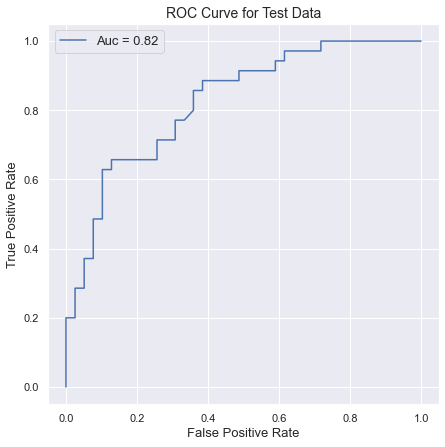

In [9]:
fpr, tpr, thresholds = roc_curve(y_true, y_proba)
auc_test = metrics.roc_auc_score(y_true, y_proba)
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.plot(fpr, tpr, label='Auc = ' + str(np.around(auc_test, decimals=2)))
ax.set_xlabel('False Positive Rate', fontsize=13)
ax.set_ylabel('True Positive Rate', fontsize=13)
ax.set_title('ROC Curve for Test Data', fontsize=14)
plt.legend(fontsize=13)
plt.savefig(testfile + '_roc_test_LOOCV.pdf', bbox_inches='tight')

In [10]:
feat_vals = np.mean(df_feat.to_numpy(), axis=1)

std_vals = np.mean(df_std.to_numpy(), axis=1)

feature_names = np.array(df_feat.index)


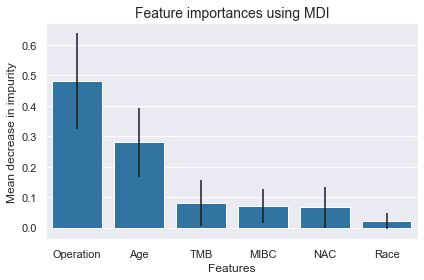

In [11]:
forest_importances = pd.DataFrame([feature_names, feat_vals, std_vals], index=['Features', 'Importances', 'STD'])
forest_importances = forest_importances.T
forest_importances.sort_values(by=['Importances'], inplace=True, ascending=False)
fig, ax = plt.subplots()
bar = sns.barplot(x='Features', y='Importances', yerr=forest_importances['STD'], ax=ax, data=forest_importances, color='tab:blue')
ax.set_title("Feature importances using MDI", fontsize=14)
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.savefig(testfile + '_feature_importance_LOOCV.pdf', bbox_inches='tight')

In [12]:
df_importances = pd.DataFrame([feature_names, feat_vals, std_vals], \
                              index=['Features', 'Importances', 'STD']).T
df_importances.to_csv(testfile + '_importances_LOOCV.txt', index=None)
df_importances

,Features,Importances,STD
0,Age,0.28009,0.113865
1,Race,0.0212827,0.0272367
2,NAC,0.0666079,0.0672116
3,MIBC,0.0697386,0.0555214
4,Operation,0.481843,0.156471
5,TMB,0.0804371,0.0744895
